## 1. Budget allocation

In [1]:
# env: zanalytics
import pandas as pd

In [2]:
df = pd.DataFrame({
    'campaign': ['A','B','C','D','E'],
    'roi': [1.0, 0.5, 1.0, 0.8, 2.5]
})

df['weight'] = df['roi'] / df['roi'].sum()
df['recommended_spend'] = df['weight'] * 250_000
print(df[['campaign','recommended_spend']])

  campaign  recommended_spend
0        A       43103.448276
1        B       21551.724138
2        C       43103.448276
3        D       34482.758621
4        E      107758.620690


## 2. Optimization model

In [3]:
from scipy.optimize import linprog

In [4]:
# Example data
conversion_rate = [0.004, 0.003, 0.0035, 0.0025, 0.006]
max_budget = 250_000
min_spend = [20_000]*5
max_spend = [100_000]*5

In [ ]:
# Objective: maximize total conversions
# linprog minimizes, so use negative conversion_rate
res = linprog(
    c=[-r for r in conversion_rate],
    bounds=list(zip(min_spend, max_spend)),
    A_eq=[[1,1,1,1,1]],
    b_eq=[max_budget],
    method='highs'
)

allocations = res.x
print("Recommended Budget Allocation:", allocations)

Recommended Budget Allocation: [ 90000.  20000.  20000.  20000. 100000.]


## 3. Simulation and workflow

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from scipy.optimize import minimize

In [7]:
# ----------------------
# Step 1: Simulate campaign data
# ----------------------
np.random.seed(42)
campaigns = ['A', 'B', 'C', 'D', 'E']

data = []
for c in campaigns:
    for week in range(1, 13):  # 12 weeks of data
        spend = np.random.uniform(20_000, 100_000)
        # Conversions follow diminishing returns: conversions = a * log(spend) + noise
        a = np.random.uniform(0.003, 0.007)  # efficiency factor
        conversions = a * np.log(spend) * 100_000 + np.random.normal(0, 5)
        data.append([c, week, spend, max(0, conversions)])  # avoid negative conversions

df = pd.DataFrame(data, columns=['campaign', 'week', 'spend', 'conversions'])
print(df.head())

  campaign  week         spend  conversions
0        A     1  49963.209508  7363.278386
1        A     2  32481.491235  3772.357855
2        A     3  24646.688973  6545.262536
3        A     4  21646.759544  6871.513610
4        A     5  86595.411264  4374.017062


In [8]:
# ----------------------
# Step 2: Train a regression model
# ----------------------
# Features: campaign (one-hot), spend
df_model = pd.get_dummies(df, columns=['campaign'])
X = df_model.drop(columns=['conversions', 'week'])
y = df_model['conversions']

model = GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=42)
model.fit(X, y)

GradientBoostingRegressor(n_estimators=200, random_state=42)

In [9]:
# ----------------------
# Step 3: Define budget optimization function
# ----------------------
total_budget = 250_000

# Helper function: predict total conversions given spend allocation
def predict_total_conversions(spends):
    # spends = array of 5 values, order corresponds to campaigns ['A','B','C','D','E']
    df_pred = pd.DataFrame([spends], columns=[f'campaign_{c}' for c in campaigns])
    return -model.predict(df_pred)[0]  # negative for minimization

# Bounds: each campaign spend between 20k and 100k
bounds = [(20_000, 100_000) for _ in campaigns]
# Constraint: sum of spends = total_budget
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - total_budget}

In [10]:
# ----------------------
# Step 4: Optimize budget allocation
# ----------------------
res = minimize(predict_total_conversions, x0=[50_000]*5, bounds=bounds, constraints=constraints)
optimal_spends = res.x
print("Optimal budget allocation per campaign:")
for c, s in zip(campaigns, optimal_spends):
    print(f"{c}: ¥{s:,.0f}")

# Predicted conversions with optimized budget
pred_conversions = -predict_total_conversions(optimal_spends)
print(f"Predicted total conversions: {pred_conversions:.0f}")


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- spend


## Marginal returns

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# campaigns from previous simulation
campaigns = ['A', 'B', 'C', 'D', 'E']

# Generate spend scenarios for each campaign (20k to 100k)
spend_range = np.linspace(20_000, 100_000, 50)

# Store predictions
predictions = {c: [] for c in campaigns}

for c_idx, c in enumerate(campaigns):
    for spend in spend_range:
        # Build input vector: other campaigns fixed at 50k
        x = [50_000]*5
        x[c_idx] = spend
        df_pred = pd.DataFrame([x], columns=[f'campaign_{cc}' for cc in campaigns])
        pred_conv = model.predict(df_pred)[0]
        predictions[c].append(pred_conv)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- spend


ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

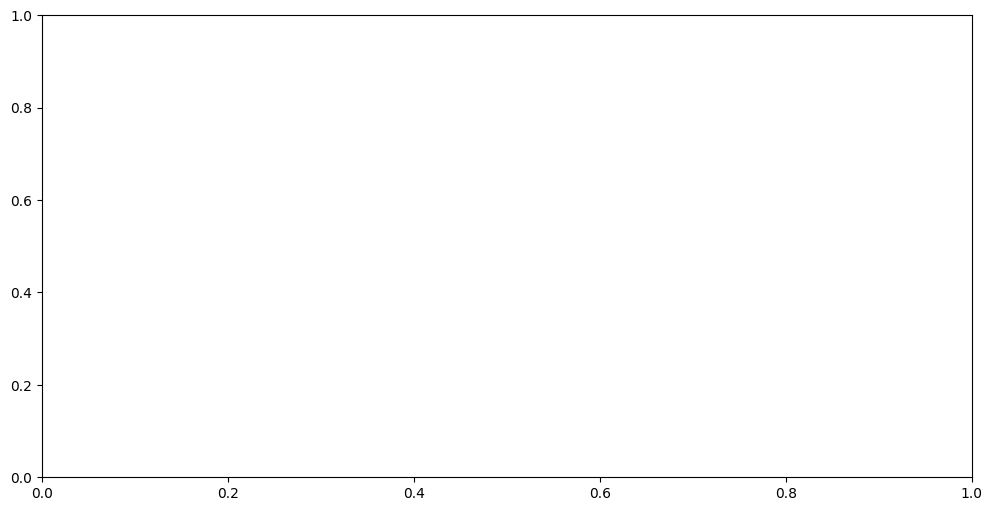

In [13]:
# ----------------------
# Step 3: Plot conversions vs budget
# ----------------------
plt.figure(figsize=(12, 6))
for c in campaigns:
    plt.plot(spend_range, predictions[c], label=f'Campaign {c}')

plt.xlabel('Budget Allocation (¥)')
plt.ylabel('Predicted Conversions')
plt.title('Predicted Conversions vs Budget per Campaign')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ----------------------
# Step 4: Compute marginal returns
# ----------------------
plt.figure(figsize=(12, 6))
for c in campaigns:
    convs = np.array(predictions[c])
    marginal = np.gradient(convs, spend_range)  # approximate derivative
    plt.plot(spend_range, marginal, label=f'Campaign {c}')

plt.xlabel('Budget Allocation (¥)')
plt.ylabel('Marginal Conversions per ¥')
plt.title('Marginal Returns vs Budget per Campaign')
plt.legend()
plt.grid(True)
plt.show()

## End to end example

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from scipy.optimize import minimize

In [52]:
# ----------------------
# Step 1: Simulate campaign data
# ----------------------
np.random.seed(42)
campaigns = ['A','B','C','D','E']
data = []

for c in campaigns:
    for week in range(1, 13):
        spend = np.random.uniform(20_000, 100_000)
        a = np.random.uniform(0.003, 0.007)  # efficiency
        conversions = a * np.log(spend) * 100_000 + np.random.normal(0, 5)
        data.append([c, week, spend, max(0, conversions)])

df = pd.DataFrame(data, columns=['campaign', 'week', 'spend', 'conversions'])

In [53]:
# ----------------------
# Step 2: Train ML model
# ----------------------
df_model = pd.get_dummies(df, columns=['campaign'])
X = df_model.drop(columns=['conversions','week'])
y = df_model['conversions']

model = GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=42)
model.fit(X, y)

GradientBoostingRegressor(n_estimators=200, random_state=42)

In [54]:
X.columns

Index(['spend', 'campaign_A', 'campaign_B', 'campaign_C', 'campaign_D',
       'campaign_E'],
      dtype='object')

In [56]:
# Spend range to simulate per campaign
spend_range = np.linspace(20_000, 100_000, 50)
predictions = {}
marginal_returns = {}

for c_idx, c in enumerate(campaigns):
    preds = []
    for spend in spend_range:
        # Build a row with all features the model expects
        row = {
            'spend': spend,  # include spend!
            'campaign_A': 50_000,
            'campaign_B': 50_000,
            'campaign_C': 50_000,
            'campaign_D': 50_000,
            'campaign_E': 50_000
        }
        # Override the spend of the campaign we are varying
        row[f'campaign_{c}'] = spend

        df_pred = pd.DataFrame([row])
        preds.append(model.predict(df_pred)[0])
    
    predictions[c] = preds
    marginal_returns[c] = np.gradient(preds, spend_range)


In [61]:
total_budget = 250_000

def predict_total_conversions(spends):
    # spends = list of 5 campaign allocations in order ['A','B','C','D','E']
    row = {
        'spend': sum(spends),  # or whatever definition makes sense for your model
        'campaign_A': spends[0],
        'campaign_B': spends[1],
        'campaign_C': spends[2],
        'campaign_D': spends[3],
        'campaign_E': spends[4],
    }
    df_pred = pd.DataFrame([row])
    return -model.predict(df_pred)[0]  # negative for minimization

# Bounds for each campaign
bounds = [(20_000, 100_000) for _ in campaigns]

# Constraint: total budget
constraints = {'type':'eq', 'fun': lambda x: np.sum(x) - total_budget}

# Run optimization
#x0 = [50_000]*5
x0 = [70000, 30000, 40000, 50000, 60000]
res = minimize(predict_total_conversions, x0=x0, bounds=bounds, constraints=constraints)

optimal_spends = res.x
pred_total_conversions = -predict_total_conversions(optimal_spends)

print("Optimal budget allocation per campaign:")
for c, s in zip(campaigns, optimal_spends):
    print(f"{c}: {s:,.0f}")

print(f"Predicted total conversions: {pred_total_conversions:.0f}")

Optimal budget allocation per campaign:
A: 70,000
B: 30,000
C: 40,000
D: 50,000
E: 60,000
Predicted total conversions: 3478


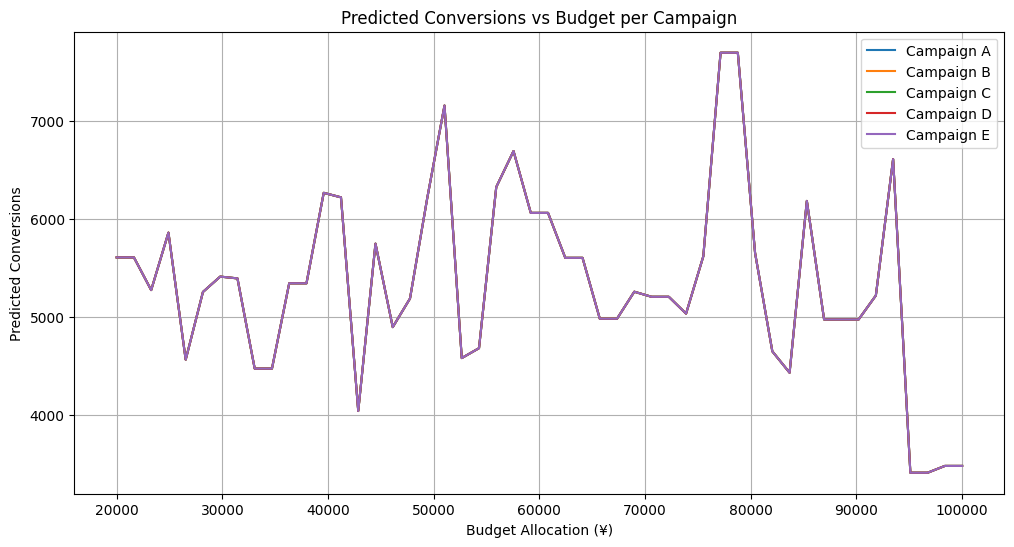

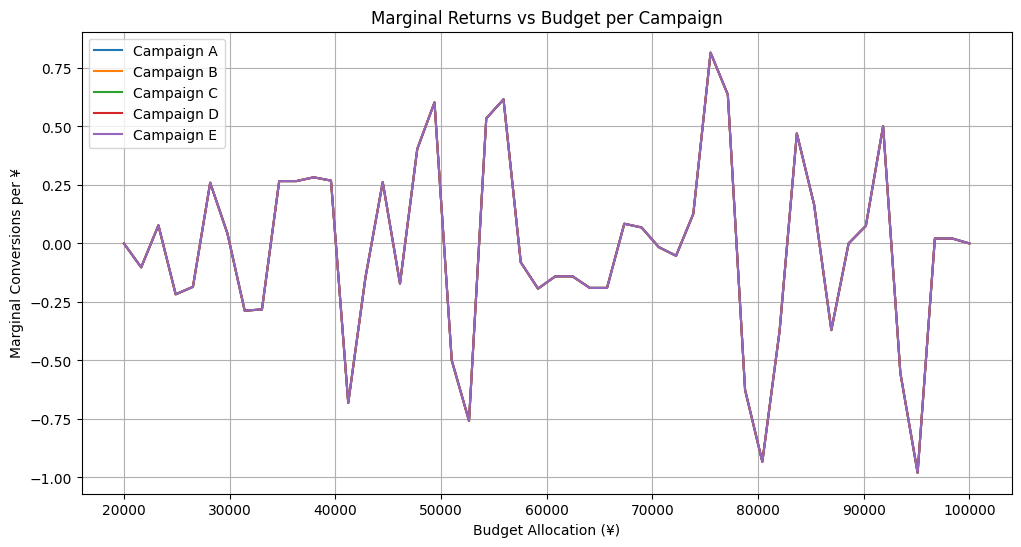

In [62]:
# ----------------------
# Step 5: Visualizations
# ----------------------
plt.figure(figsize=(12,6))
for c in campaigns:
    plt.plot(spend_range, predictions[c], label=f'Campaign {c}')
plt.xlabel('Budget Allocation (¥)')
plt.ylabel('Predicted Conversions')
plt.title('Predicted Conversions vs Budget per Campaign')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
for c in campaigns:
    plt.plot(spend_range, marginal_returns[c], label=f'Campaign {c}')
plt.xlabel('Budget Allocation (¥)')
plt.ylabel('Marginal Conversions per ¥')
plt.title('Marginal Returns vs Budget per Campaign')
plt.legend()
plt.grid(True)
plt.show()


In [63]:
# ----------------------
# Step 6: Recommendations
# ----------------------
recommendations = []
for c, spend in zip(campaigns, optimal_spends):
    mr = marginal_returns[c][np.abs(spend_range - spend).argmin()]
    if mr < 0.01:  # threshold for low marginal return
        rec = f"⚠️ Campaign {c}: marginal returns are low at allocated budget ¥{spend:,.0f}. Consider reallocation."
    else:
        rec = f"✅ Campaign {c}: budget allocation ¥{spend:,.0f} is effective."
    recommendations.append(rec)

print("Optimal Budget Allocation & Recommendations:")
for r in recommendations:
    print(r)

print(f"\nPredicted Total Conversions: {pred_total_conversions:.0f}")


Optimal Budget Allocation & Recommendations:
⚠️ Campaign A: marginal returns are low at allocated budget ¥70,000. Consider reallocation.
✅ Campaign B: budget allocation ¥30,000 is effective.
✅ Campaign C: budget allocation ¥40,000 is effective.
✅ Campaign D: budget allocation ¥50,000 is effective.
⚠️ Campaign E: marginal returns are low at allocated budget ¥60,000. Consider reallocation.

Predicted Total Conversions: 3478


## Simulating sessions

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [19]:
np.random.seed(42)

# Parameters
chatbots = ['bot_tokyo', 'bot_osaka', 'bot_nagoya']
tenants = ['client123', 'client456']
n_sessions = 100  # number of sessions to simulate

# Generate sessions
sessions_data = []
for _ in range(n_sessions):
    chatbot = np.random.choice(chatbots)
    tenant = np.random.choice(tenants)
    session_id = f"sess_{np.random.randint(1000, 9999)}"
    user_id = f"user_{np.random.randint(100, 999)}"
    start_time = datetime(2025, 10, np.random.randint(1, 20), np.random.randint(0,24), np.random.randint(0,60))
    end_time = start_time + timedelta(minutes=np.random.randint(1,15))
    channel = np.random.choice(['LINE','Web','Messenger'])
    messages = np.random.randint(1, 20)
    completed = np.random.choice([True, False], p=[0.7, 0.3])
    
    sessions_data.append([session_id, chatbot, tenant, user_id, start_time, end_time, channel, messages, completed])

chatbot_sessions = pd.DataFrame(sessions_data, columns=[
    'session_id','chatbot_id','tenant_id','user_id','start_time','end_time','channel','messages','completed'
])

print(chatbot_sessions.head())


  session_id  chatbot_id  tenant_id   user_id          start_time  \
0  sess_1860  bot_nagoya  client456  user_370 2025-10-11 07:20:00   
1  sess_9322  bot_nagoya  client456  user_761 2025-10-02 23:43:00   
2  sess_5555   bot_tokyo  client123  user_413 2025-10-12 16:26:00   
3  sess_3734  bot_nagoya  client456  user_662 2025-10-12 22:51:00   
4  sess_6393   bot_tokyo  client123  user_487 2025-10-14 17:57:00   

             end_time    channel  messages  completed  
0 2025-10-11 07:27:00        Web        19       True  
1 2025-10-02 23:57:00        Web         2       True  
2 2025-10-12 16:37:00  Messenger        10       True  
3 2025-10-12 23:00:00  Messenger         5       True  
4 2025-10-14 18:06:00        Web         2       True  


In [20]:
# Each session can have multiple events/intents
events_data = []
for _, row in chatbot_sessions.iterrows():
    n_events = np.random.randint(1, 6)  # events per session
    for i in range(n_events):
        event_id = f"evt_{np.random.randint(10000,99999)}"
        intent_name = np.random.choice(['Buy_Product','FAQ','Support','Feedback'])
        confidence = np.round(np.random.uniform(0.6,1.0),2)
        response_time_ms = np.random.randint(200,2000)
        resolved = np.random.choice([True, False], p=[0.8,0.2])
        conversion_value = np.round(np.random.uniform(0,50),2) if resolved else 0
        timestamp = row['start_time'] + timedelta(seconds=np.random.randint(0,600))
        
        events_data.append([event_id, row['session_id'], row['chatbot_id'], row['tenant_id'],
                            intent_name, confidence, response_time_ms, resolved, conversion_value, timestamp])

chatbot_events = pd.DataFrame(events_data, columns=[
    'event_id','session_id','chatbot_id','tenant_id','intent_name','confidence',
    'response_time_ms','resolved','conversion_value','timestamp'
])

print(chatbot_events.head())


    event_id session_id  chatbot_id  tenant_id intent_name  confidence  \
0  evt_13756  sess_1860  bot_nagoya  client456         FAQ        0.60   
1  evt_81315  sess_1860  bot_nagoya  client456     Support        0.98   
2  evt_86077  sess_1860  bot_nagoya  client456     Support        0.66   
3  evt_49915  sess_1860  bot_nagoya  client456    Feedback        0.97   
4  evt_37632  sess_9322  bot_nagoya  client456    Feedback        0.75   

   response_time_ms  resolved  conversion_value           timestamp  
0               826      True             27.14 2025-10-11 07:24:42  
1              1071      True             20.04 2025-10-11 07:25:45  
2               340      True              5.04 2025-10-11 07:27:39  
3              1356     False              0.00 2025-10-11 07:22:06  
4              1213      True              5.21 2025-10-02 23:47:56  


In [21]:
# Cost per chatbot per month
months = pd.date_range(start='2025-10-01', periods=1, freq='MS')
costs_data = []

for chatbot in chatbots:
    for tenant in tenants:
        for month in months:
            api_cost = np.random.uniform(50,150)
            infra_cost = np.random.uniform(20,50)
            human_handoff_cost = np.random.uniform(30,80)
            total_cost = api_cost + infra_cost + human_handoff_cost
            costs_data.append([chatbot, tenant, month.date(), api_cost, infra_cost, human_handoff_cost, total_cost])

chatbot_costs = pd.DataFrame(costs_data, columns=[
    'chatbot_id','tenant_id','period_date','api_cost','infra_cost','human_handoff_cost','total_cost'
])

print(chatbot_costs.head())


   chatbot_id  tenant_id period_date    api_cost  infra_cost  \
0   bot_tokyo  client123  2025-10-01  102.627846   33.895182   
1   bot_tokyo  client456  2025-10-01   80.319406   28.699104   
2   bot_osaka  client123  2025-10-01   61.995369   47.503751   
3   bot_osaka  client456  2025-10-01   90.144563   24.758724   
4  bot_nagoya  client123  2025-10-01  132.377809   41.651647   

   human_handoff_cost  total_cost  
0           41.732672  178.255700  
1           58.164447  167.182956  
2           66.032757  175.531877  
3           74.099608  189.002896  
4           43.577352  217.606808  


In [22]:
# Aggregate total conversion per chatbot
conversion_summary = chatbot_events.groupby(['chatbot_id','tenant_id'])['conversion_value'].sum().reset_index()

# Merge with cost data
roi_df = conversion_summary.merge(
    chatbot_costs.groupby(['chatbot_id','tenant_id'])['total_cost'].sum().reset_index(),
    on=['chatbot_id','tenant_id']
)

# Compute ROI
roi_df['roi'] = (roi_df['conversion_value'] - roi_df['total_cost']) / roi_df['total_cost']

print(roi_df)


   chatbot_id  tenant_id  conversion_value  total_cost       roi
0  bot_nagoya  client123           1062.87  217.606808  3.884360
1  bot_nagoya  client456            985.00  152.779088  5.447217
2   bot_osaka  client123           1260.40  175.531877  6.180462
3   bot_osaka  client456            604.10  189.002896  2.196247
4   bot_tokyo  client123            969.88  178.255700  4.440948
5   bot_tokyo  client456           1295.68  167.182956  6.750072


## Example

In [23]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingRegressor
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [24]:
np.random.seed(42)

# --- Parameters ---
chatbots = ['bot_tokyo','bot_osaka','bot_nagoya']
tenants = ['client123','client456']
n_sessions = 200

In [25]:
# ----------------------
# 1️⃣ Simulate chatbot_sessions
# ----------------------
sessions_data = []
for _ in range(n_sessions):
    chatbot = np.random.choice(chatbots)
    tenant = np.random.choice(tenants)
    session_id = f"sess_{np.random.randint(1000,9999)}"
    user_id = f"user_{np.random.randint(100,999)}"
    start_time = datetime(2025,10,np.random.randint(1,20), np.random.randint(0,24), np.random.randint(0,60))
    end_time = start_time + timedelta(minutes=np.random.randint(1,15))
    channel = np.random.choice(['LINE','Web','Messenger'])
    messages = np.random.randint(1,20)
    completed = np.random.choice([True, False], p=[0.7,0.3])
    
    sessions_data.append([session_id, chatbot, tenant, user_id, start_time, end_time, channel, messages, completed])

chatbot_sessions = pd.DataFrame(sessions_data, columns=[
    'session_id','chatbot_id','tenant_id','user_id','start_time','end_time','channel','messages','completed'
])

In [26]:
# ----------------------
# 2️⃣ Simulate chatbot_events
# ----------------------
events_data = []
for _, row in chatbot_sessions.iterrows():
    n_events = np.random.randint(1,5)
    for i in range(n_events):
        event_id = f"evt_{np.random.randint(10000,99999)}"
        intent_name = np.random.choice(['Buy_Product','FAQ','Support','Feedback'])
        confidence = np.round(np.random.uniform(0.6,1.0),2)
        response_time_ms = np.random.randint(200,2000)
        resolved = np.random.choice([True,False], p=[0.8,0.2])
        conversion_value = np.round(np.random.uniform(0,50),2) if resolved else 0
        timestamp = row['start_time'] + timedelta(seconds=np.random.randint(0,600))
        
        events_data.append([event_id, row['session_id'], row['chatbot_id'], row['tenant_id'],
                            intent_name, confidence, response_time_ms, resolved, conversion_value, timestamp])

chatbot_events = pd.DataFrame(events_data, columns=[
    'event_id','session_id','chatbot_id','tenant_id','intent_name','confidence',
    'response_time_ms','resolved','conversion_value','timestamp'
])

In [27]:
# ----------------------
# 3️⃣ Simulate chatbot_costs
# ----------------------
months = pd.date_range(start='2025-10-01', periods=1, freq='MS')
costs_data = []

for chatbot in chatbots:
    for tenant in tenants:
        for month in months:
            api_cost = np.random.uniform(50,150)
            infra_cost = np.random.uniform(20,50)
            human_handoff_cost = np.random.uniform(30,80)
            total_cost = api_cost + infra_cost + human_handoff_cost
            costs_data.append([chatbot, tenant, month.date(), api_cost, infra_cost, human_handoff_cost, total_cost])

chatbot_costs = pd.DataFrame(costs_data, columns=[
    'chatbot_id','tenant_id','period_date','api_cost','infra_cost','human_handoff_cost','total_cost'
])

In [28]:
# Aggregate conversion per chatbot
conversion_summary = chatbot_events.groupby(['chatbot_id','tenant_id'])['conversion_value'].sum().reset_index()

# Merge with cost data
roi_df = conversion_summary.merge(
    chatbot_costs.groupby(['chatbot_id','tenant_id'])['total_cost'].sum().reset_index(),
    on=['chatbot_id','tenant_id']
)

# Compute ROI
roi_df['roi'] = (roi_df['conversion_value'] - roi_df['total_cost']) / roi_df['total_cost']

print("ROI per Chatbot:")
print(roi_df)


ROI per Chatbot:
   chatbot_id  tenant_id  conversion_value  total_cost        roi
0  bot_nagoya  client123           1504.21  142.590941   9.549127
1  bot_nagoya  client456           2195.99  194.478115  10.291708
2   bot_osaka  client123           1844.46  211.115208   7.736746
3   bot_osaka  client456           1175.18  176.075732   5.674287
4   bot_tokyo  client123           2013.02  156.962252  11.824867
5   bot_tokyo  client456           1584.72  247.482257   5.403368


In [31]:
# Aggregate spend & conversion for ML (simulate spend as total cost)
ml_df = roi_df.copy()
ml_df['spend'] = ml_df['total_cost']

# One-hot encode chatbot_id
ml_df_encoded = pd.get_dummies(ml_df, columns=['chatbot_id'])
ml_df_encoded.head()

,tenant_id,conversion_value,total_cost,roi,spend,chatbot_id_bot_nagoya,chatbot_id_bot_osaka,chatbot_id_bot_tokyo
0,client123,1504.21,142.590941,9.549127,142.590941,True,False,False
1,client456,2195.99,194.478115,10.291708,194.478115,True,False,False
2,client123,1844.46,211.115208,7.736746,211.115208,False,True,False
3,client456,1175.18,176.075732,5.674287,176.075732,False,True,False
4,client123,2013.02,156.962252,11.824867,156.962252,False,False,True


In [33]:
X = ml_df_encoded.drop(columns=['tenant_id','conversion_value','roi','total_cost'])
y = ml_df_encoded['conversion_value']

# Train model
model = GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=42)
model.fit(X, y)

GradientBoostingRegressor(n_estimators=200, random_state=42)

In [35]:
X.columns

Index(['spend', 'chatbot_id_bot_nagoya', 'chatbot_id_bot_osaka',
       'chatbot_id_bot_tokyo'],
      dtype='object')

In [38]:
total_budget = 500  # in same units as simulated cost


#def predict_total_conversion(spends):
#    # spends = array for each chatbot in order ['bot_tokyo','bot_osaka','bot_nagoya']
#    df_pred = pd.DataFrame([spends], columns=[f'chatbot_id_{c}' for c in chatbots])
#    return -model.predict(df_pred)[0]  # negative for minimization


def predict_total_conversion(spends):
    # spends: array for each chatbot in order ['bot_tokyo','bot_osaka','bot_nagoya']
    df_pred = pd.DataFrame([{
        'spend': np.sum(spends),  # or another appropriate definition
        'chatbot_id_bot_nagoya': spends[0],
        'chatbot_id_bot_osaka': spends[1],
        'chatbot_id_bot_tokyo': spends[2],
    }])
    return -model.predict(df_pred)[0]


In [39]:

bounds = [(50, 200)] * len(chatbots)  # min/max spend per chatbot
constraints = {'type':'eq', 'fun': lambda x: np.sum(x) - total_budget}

res = minimize(predict_total_conversion, x0=[150]*3, bounds=bounds, constraints=constraints)
optimal_spends = res.x
predicted_total_conversions = -predict_total_conversion(optimal_spends)

print("Optimal Budget Allocation per Chatbot:")
for c, s in zip(chatbots, optimal_spends):
    print(f"{c}: {s:.2f}")

print(f"Predicted Total Conversions: {predicted_total_conversions:.2f}")

Optimal Budget Allocation per Chatbot:
bot_tokyo: 166.67
bot_osaka: 166.67
bot_nagoya: 166.67
Predicted Total Conversions: 1926.41


In [40]:
recommendations = []
for c, spend in zip(chatbots, optimal_spends):
    idx = np.abs(np.array([50,100,150,200]) - spend).argmin()  # approximate marginal returns
    marginal_return = predicted_total_conversions / spend  # rough
    if marginal_return < 0.5:
        recommendations.append(f"⚠️ {c}: Low return at allocated budget {spend:.2f}")
    else:
        recommendations.append(f"✅ {c}: Effective allocation {spend:.2f}")

print("\nRecommendations:")
for r in recommendations:
    print(r)



Recommendations:
✅ bot_tokyo: Effective allocation 166.67
✅ bot_osaka: Effective allocation 166.67
✅ bot_nagoya: Effective allocation 166.67


In [46]:
predictions = {}
marginal_returns = {}

for c_idx, c in enumerate(chatbots):
    preds = []
    for spend in spend_range:
        # Build input row with same columns as training
        row = {
            'spend': spend,  # include spend!
            'chatbot_id_bot_nagoya': 150 if c != 'bot_nagoya' else spend,
            'chatbot_id_bot_osaka': 150 if c != 'bot_osaka' else spend,
            'chatbot_id_bot_tokyo': 150 if c != 'bot_tokyo' else spend
        }
        df_pred = pd.DataFrame([row])
        preds.append(model.predict(df_pred)[0])
    
    predictions[c] = preds
    marginal_returns[c] = np.gradient(preds, spend_range)  # approximate derivative

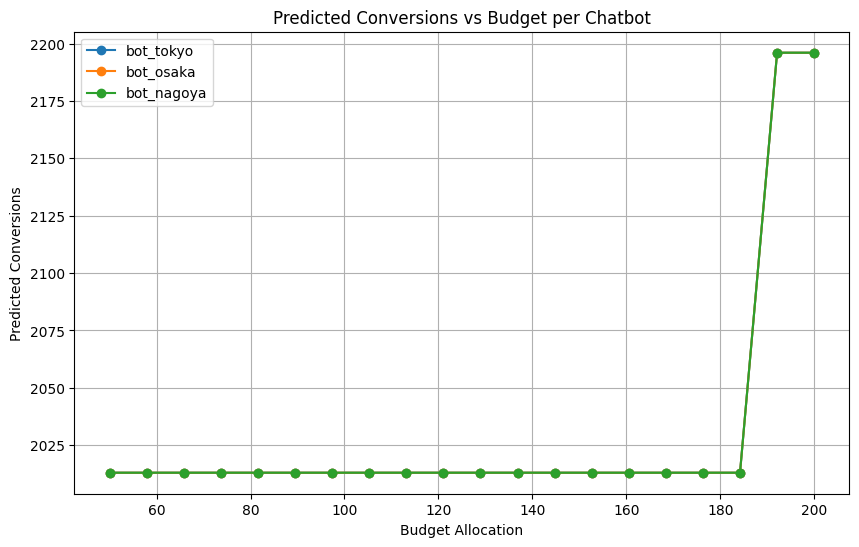

In [47]:
plt.figure(figsize=(10,6))
for c in chatbots:
    plt.plot(spend_range, predictions[c], marker='o', label=f'{c}')
plt.xlabel('Budget Allocation')
plt.ylabel('Predicted Conversions')
plt.title('Predicted Conversions vs Budget per Chatbot')
plt.legend()
plt.grid(True)
plt.show()


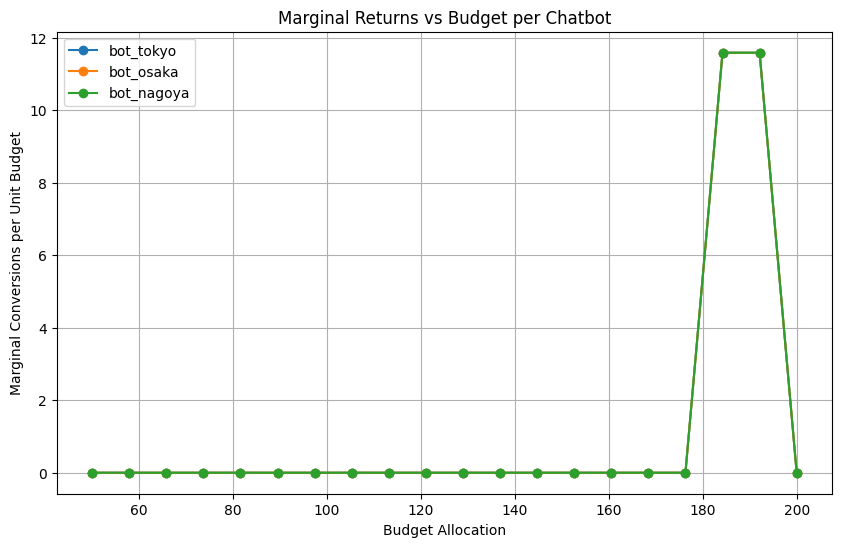

In [48]:
plt.figure(figsize=(10,6))
for c in chatbots:
    plt.plot(spend_range, marginal_returns[c], marker='o', label=f'{c}')
plt.xlabel('Budget Allocation')
plt.ylabel('Marginal Conversions per Unit Budget')
plt.title('Marginal Returns vs Budget per Chatbot')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
recommendations = []
for c_idx, c in enumerate(chatbots):
    # find closest index in spend_range for optimized spend
    idx = np.abs(spend_range - optimal_spends[c_idx]).argmin()
    mr = marginal_returns[c][idx]
    if mr < 0.05:  # threshold for low marginal return
        recommendations.append(f"⚠️ {c}: marginal returns low at allocated budget {optimal_spends[c_idx]:.2f}")
    else:
        recommendations.append(f"✅ {c}: allocation effective at {optimal_spends[c_idx]:.2f}")

print("\nUpdated Recommendations with Marginal Returns:")
for r in recommendations:
    print(r)


Updated Recommendations with Marginal Returns:
⚠️ bot_tokyo: marginal returns low at allocated budget 166.67
⚠️ bot_osaka: marginal returns low at allocated budget 166.67
⚠️ bot_nagoya: marginal returns low at allocated budget 166.67
